## 1. 라이브러리 불러오기

In [2]:
import sys
import glob
import cv2
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils, datasets, models
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

from torch.autograd import Variable

from matplotlib import pyplot as plt
from time import time

import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

import wandb

from augraphy import *

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

## 2. Custom Dataset

In [4]:
class ImageDataset(Dataset):
    def __init__(self, csv, path, album_transform=None, augraphy_transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path 
        self.album_transform = album_transform
        self.augraphy_transform = augraphy_transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        if self.augraphy_transform:
            img = self.augraphy_transform(img)

        if self.album_transform:
            img = self.album_transform(image=img)['image']
        
        return img, target

## 3. Training Pipeline

In [5]:
def training(model, dataloader, dataset, device, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    preds_list = []
    targets_list = []

    tbar = tqdm(dataloader)
    for images, labels in tbar:
        images = images.type(torch.cuda.FloatTensor)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(outputs.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(labels.detach().cpu().numpy())

        tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss : {loss.item():.4f}")

    train_loss = train_loss / (len(dataloader))
    train_acc = accuracy_score(preds_list, targets_list)
    train_f1 = f1_score(preds_list, targets_list, average='macro')

    metrics = {
        'train_loss' : train_loss,
        'train_acc' : train_acc,
        'train_f1' : train_f1
    }

    return model, metrics

def evaluation(model, dataloader, dataset, device, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    preds_list = []
    targets_list = []

    with torch.no_grad():
        tbar = tqdm(dataloader)
        for images, labels in tbar:
            images = images.type(torch.cuda.FloatTensor)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            preds_list.extend(outputs.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(labels.detach().cpu().numpy())

            tbar.set_description(f"Epcoh [{epoch+1}/{num_epochs}] Valid Loss : {valid_loss:.4f}")

    valid_loss /= len(dataloader)
    valid_acc = accuracy_score(preds_list, targets_list)
    valid_f1 = f1_score(preds_list, targets_list, average='macro')

    metrics = {
        'valid_loss' : valid_loss,
        'valid_acc' : valid_acc,
        'valid_f1' : valid_f1
    }

    return model, metrics

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, model_path, model_name, patience, run):

    best_valid_loss = float('inf')
    valid_max_accuracy = -1
    valid_max_f1 = -1
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model, train_metrics = training(model, train_dataloader, train_dataset, device, criterion, optimizer, epoch, num_epochs)
        model, valid_metrics = evaluation(model, valid_dataloader, valid_dataset, device, criterion, epoch, num_epochs)

        monitoring_value = {
            'train_loss' : train_metrics['train_loss'],
            'train_accuracy' : train_metrics['train_acc'],
            'train_f1' : train_metrics['train_f1'],
            'valid_loss' : valid_metrics['valid_loss'],
            'valid_accuracy' : valid_metrics['valid_acc'],
            'valid_f1' : valid_metrics['valid_f1']
        }
        run.log(monitoring_value, step=epoch)

        if valid_max_accuracy < valid_metrics['valid_acc']:
            valid_max_accuracy = valid_metrics['valid_acc']

            run.summary['best_train_acc'] = train_metrics['train_acc']
            run.summary['best_valid_acc'] = valid_metrics['valid_acc']
        
        if valid_max_f1 < valid_metrics['valid_f1']:
            valid_max_f1 = valid_metrics['valid_f1']
            torch.save(model.state_dict(), model_path+f"/model_{model_name}.pt")

            run.summary['best_train_f1'] = train_metrics['train_f1']
            run.summary['best_valid_f1'] = valid_metrics['valid_f1']

        if best_valid_loss > valid_metrics['valid_loss']:
            best_valid_loss = valid_metrics['valid_loss']
            early_stop_counter = 0
            run.summary['best_train_loss'] = train_metrics['train_loss']
            run.summary['best_valid_loss'] = valid_metrics['valid_loss']
        else:
            early_stop_counter += 1
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss : {train_metrics['train_loss']:.4f}, Train Acc : {train_metrics['train_acc']:.4f}, 'Train F1 : {train_metrics['train_f1']:.4f}, Valid Loss : {valid_metrics['valid_loss']:.4f}, Valid Acc : {valid_metrics['valid_acc']:.4f}, Valid F1 : {valid_metrics['valid_f1']}")

        if early_stop_counter >= patience:
            print('Early Stopping!')        
            break

    return model, valid_max_accuracy, valid_max_f1


In [17]:
train_path = '../data/train.csv'

train = pd.read_csv(train_path)


In [19]:
train.target.value_counts()

target
16    100
10    100
0     100
3     100
12    100
8     100
2     100
11    100
7     100
9     100
15    100
5     100
4     100
6     100
13     74
14     50
1      46
Name: count, dtype: int64

## 4. Data Load

In [14]:
submission_path = '../../../data/sample_submission.csv'
test_path = '../../../data/test/'

In [15]:
test_transform = A.Compose([
    A.Resize(380, 380),
    ToTensorV2()
])

test_dataset = ImageDataset(submission_path, test_path, album_transform=test_transform, augraphy_transform=None)

print(len(test_dataset))

3140


In [19]:

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=2, shuffle=False)

## 5. Train Model

In [18]:
model = timm.create_model('efficientnet_b4', pretrained=True)
in_features = model.classifier.in_features
classifier = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 17),
)

model.classifier = classifier

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

### Hyper Parameter 정의

In [19]:
class Cfg():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100
    batch_size=32
    model_path = '/data/ephemeral/home/upstage_cv/models'

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

effb4 = timm.create_model('efficientnet_b4', pretrained=True)
in_features = effb4.classifier.in_features
classifier = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 17),
)

effb4.classifier = classifier
effb4.load_state_dict(torch.load('../../../model_effb4-add_fc.pt'))
effb4 = effb4.to(device)
effb4.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [11]:
meta = pd.read_csv('../data/meta.csv')
class_mapping = pd.Series(meta.class_name.values, index=meta.target).to_dict()


In [12]:
class_mapping

{0: 'account_number',
 1: 'application_for_payment_of_pregnancy_medical_expenses',
 2: 'car_dashboard',
 3: 'confirmation_of_admission_and_discharge',
 4: 'diagnosis',
 5: 'driver_lisence',
 6: 'medical_bill_receipts',
 7: 'medical_outpatient_certificate',
 8: 'national_id_card',
 9: 'passport',
 10: 'payment_confirmation',
 11: 'pharmaceutical_receipt',
 12: 'prescription',
 13: 'resume',
 14: 'statement_of_opinion',
 15: 'vehicle_registration_certificate',
 16: 'vehicle_registration_plate'}

In [15]:
import torch.nn.functional as F


predictions = []
images_to_log = []

wandb.init(project="aistages-OCR", entity = "hewberryd8")



with torch.no_grad():  # 그라디언트 계산 비활성화
    for images, _ in test_dataloader:
        images = images.to(device).float()  # 이미지를 FloatTensor로 변환 및 정규화
        outputs = effb4(images)
        
        # Softmax를 적용하여 각 클래스에 대한 확률을 계산
        probs = F.softmax(outputs, dim=1)
        
        # topk를 사용하여 상위 2개 예측값과 인덱스 가져오기
        top_probs, top_preds = probs.topk(2, dim=1)
        
        for img, top_pred, top_prob in zip(images, top_preds, top_probs):
            first_label = class_mapping[int(top_pred[0])]
            first_prob = top_prob[0].item()
            second_label = class_mapping[int(top_pred[1])]
            second_prob = top_prob[1].item()
            
            caption = f"1st Pred: {first_label}, Prob: {first_prob:.4f}; 2nd Pred: {second_label}, Prob: {second_prob:.4f}"
            
            # 이미지, 예측 라벨, 예측 확률을 wandb에 로깅
            wandb.log({"Predictions": [wandb.Image(img.cpu(), caption=caption)]})

wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [16]:
predictions = []
images_to_log = []

wandb.init(project="aistages-OCR", entity = "hewberryd8")





with torch.no_grad():  # 그라디언트 계산 비활성화
    for images, _ in test_dataloader:
        images = images.to(device).float()
        outputs = effb4(images)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_preds = probs.topk(2, dim=1)
        
        for img, top_pred, top_prob in zip(images, top_preds, top_probs):
            # 확률이 0.99 이상인 경우 로깅 제외
            if top_prob[0].item() < 0.99:
                first_label = class_mapping[int(top_pred[0])]
                first_prob = top_prob[0].item()
                second_label = class_mapping[int(top_pred[1])]
                second_prob = top_prob[1].item()
                
                caption = f"1st Pred: {first_label}, Prob: {first_prob:.4f}; 2nd Pred: {second_label}, Prob: {second_prob:.4f}"
                
                wandb.log({"Predictions": [wandb.Image(img.cpu(), caption=caption)]})


wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [22]:

pred_list = []
with torch.no_grad():  # 그라디언트 계산 비활성화
    for images, _ in test_dataloader:
        images = images.to(device).float()
        outputs = effb4(images)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_preds = probs.topk(1, dim=1)
        pred_list.extend(top_probs)
        print(top_probs)
        print(top_preds)


print(pred_list)


tensor([[1.0000],
        [0.9927],
        [1.0000],
        [0.6586],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9987],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9039],
        [1.0000],
        [1.0000],
        [0.7210],
        [1.0000],
        [0.9869],
        [0.5279],
        [1.0000],
        [0.9917],
        [1.0000],
        [0.9940],
        [1.0000],
        [0.9754],
        [1.0000],
        [0.8715],
        [1.0000]], device='cuda:0')
tensor([[ 2],
        [12],
        [ 5],
        [ 4],
        [ 2],
        [15],
        [ 0],
        [ 8],
        [15],
        [11],
        [ 5],
        [ 7],
        [16],
        [ 9],
        [15],
        [ 4],
        [ 7],
        [ 5],
        [13],
        [11],
        [12],
        [12],
        [ 1],
        [ 6],
        [ 3],
        [ 0],
        [ 7],
        [16],
        [12],


In [26]:
pred_list_cat = torch.cat(pred_list)


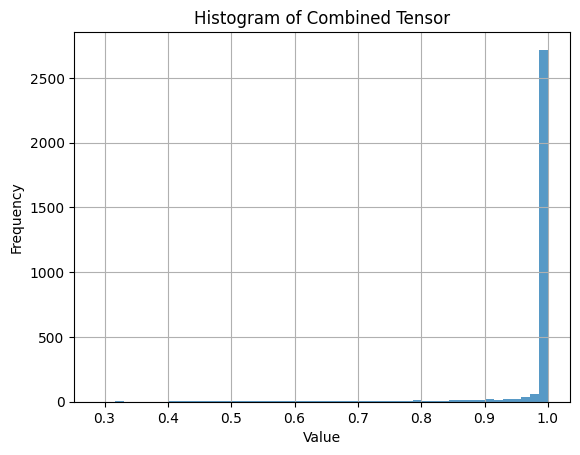

In [29]:
numpy_array =pred_list_cat.cpu().numpy() 
plt.hist(numpy_array, bins=50, alpha=0.75)  # bins는 히스토그램의 바구니 수를 조정
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Tensor')
plt.grid(True)
plt.show()

In [13]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [22]:
preds_list = []

for images, labels in tqdm(test_dataloader):
    images = images.type(torch.cuda.FloatTensor)
    images = images.to(device)

    with torch.no_grad():
        preds = effb4(images)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:29<00:00,  3.30it/s]


In [23]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [24]:
sample_submission_df = pd.read_csv(submission_path)
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [25]:
pred_df.to_csv('../outputs/effb4-add_fc.csv', index=False)

In [26]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,4
4,00901f504008d884.jpg,2
